In [7]:
import yaml
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import skimage.io as io
import pylab

pylab.rcParams["figure.figsize"] = (10.0, 8.0)

In [9]:
annType = ["segm", "bbox", "keypoints"]
annType = annType[2]  # specify type here
prefix = "person_keypoints" if annType == "keypoints" else "instances"
print("Running demo for *%s* results." % (annType))

Running demo for *keypoints* results.


In [3]:
def load_yaml(path: str) -> dict:
    """Load yaml file to dict"""
    with open(path, "r") as file:
        yaml_dct = yaml.safe_load(file)
    return yaml_dct

In [36]:
cocoGt = COCO("person_keypoints_val2017.json")

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [56]:
cocoDt = cocoGt.loadRes("results.json")

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [57]:
imgIds = sorted(cocoDt.getImgIds())
imgIds = imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

In [63]:
img_ids = [ann["image_id"] for i, ann in cocoDt.anns.items()]

In [64]:
cocoEval = COCOeval(cocoGt, cocoDt, annType)
cocoEval.params.imgIds = img_ids
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 1.000


In [65]:
cocoEval.stats

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

KeyError: 1

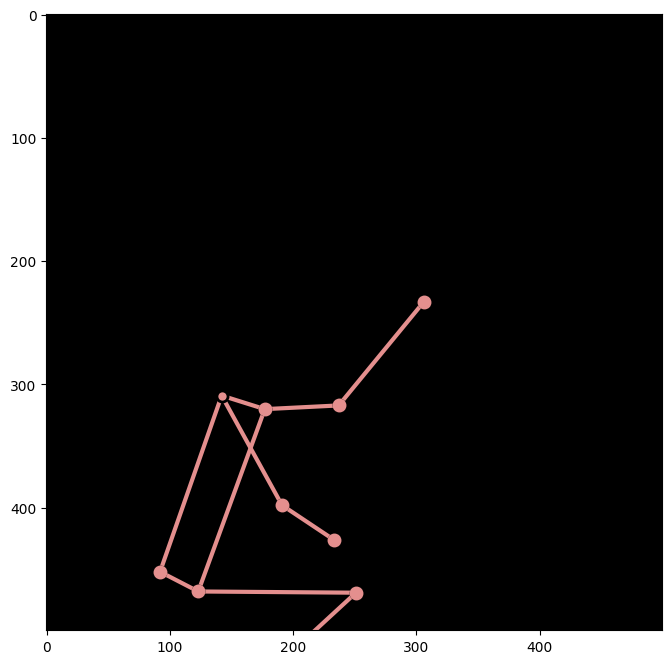

In [50]:
plt.figure()
plt.imshow(np.zeros((500, 500, 3)))
cocoDt.showAnns([cocoDt.anns[1]])
cocoGt.showAnns([cocoGt.anns[1]])

In [ ]:
import numpy as np
import cv2

: 

In [90]:
paths = [[(0, 0), (1, 1), (1, 0)], [(5, 4), (2, 3), (3, 7), (8, 9)]]
area = sum(cv2.contourArea(np.array(path)) for path in paths)

In [141]:
target_kpts = np.random.randint(0, 100, (4, 17, 3))
pred_kpts = np.random.randint(0, 100, (20, 17, 3))
pred_kpts[5] = target_kpts[0]
pred_kpts[7] = target_kpts[1]
pred_kpts[9] = target_kpts[2]
pred_kpts[11] = target_kpts[3]

In [148]:
sigmas = [26, 25, 25, 35, 35, 79, 79, 72, 72, 62, 62, 107, 107, 87, 87, 89, 89]
sigmas = np.array(sigmas) / 1000
vars = (sigmas * 2) ** 2


def calculate_oks(pred_kpts, target_kpts, obj_polygons):
    # pred_kpts shape: [num_kpts, 2]
    # target_kpts shape: [num_kpts, 2]
    # 2 for: x, y
    num_kpts = len(target_kpts)

    kpts_vis = np.array([x > 0 or y > 0 for x, y in target_kpts[..., :2]])

    area = sum(cv2.contourArea(np.array(poly)) for poly in obj_polygons)

    dist = ((pred_kpts - target_kpts) ** 2).sum(-1)

    e = dist / vars / (area + np.spacing(1)) / 2
    e = e[kpts_vis]
    return np.sum(np.exp(-e)) / num_kpts


def match_predictions_to_targets(pred_kpts, target_kpts, objects_polygons):
    # pred_kpts shape: [num_obj_pred, num_kpts, 3]
    # 3 for: x, y, score
    # target_kpts shape: [num_obj_target, num_kpts, 2]
    # 2 for: x, y
    # objects_polygons is list of ground truth polygons (for area calculation)
    num_target_obj, num_kpts = target_kpts.shape[:2]
    pred_obj_scores = pred_kpts[..., 2].mean(-1)
    sorted_idxs = np.argsort(pred_obj_scores, kind="mergesort")
    target_matches_idx = [-1 for _ in range(num_target_obj)]
    target_matches_oks = [0 for _ in range(num_target_obj)]
    matched_idxs = []
    for pred_idx in sorted_idxs:
        p_kpts = pred_kpts[pred_idx]
        for target_idx, t_kpts in enumerate(target_kpts):
            if target_idx in matched_idxs:
                continue
            obj_polygons = objects_polygons[target_idx]
            obj_oks = calculate_oks(p_kpts[..., :2], t_kpts[..., :2], obj_polygons)
            if obj_oks > target_matches_oks[target_idx]:
                target_matches_oks[target_idx] = obj_oks
                print("HE", pred_idx, target_idx)
                target_matches_idx[target_idx] = pred_idx
                matched_idxs.append(target_idx)
    return target_matches_idx, target_matches_oks

In [149]:
pred_obj_scores = pred_kpts[..., 2].mean(-1)
sorted_idxs = np.argsort(pred_obj_scores, kind="mergesort")
obj_polygons = [[(10, 15), (20, 25), (1, 18)]]

In [150]:
match_predictions_to_targets(pred_kpts, target_kpts)

HE 0 0
HE 0 1
HE 0 2
HE 0 3
HE 1 0
HE 1 2
HE 1 3
HE 2 2
HE 4 0
HE 4 2
HE 5 0
HE 6 3
HE 7 1
HE 9 2
HE 9 3
HE 11 3


([5, 7, 9, 11], [1.0, 1.0, 1.0, 1.0])

In [151]:
calculate_oks(pred_kpts[5], target_kpts[0], obj_polygons)

1.0

In [152]:
pred_kpts[9]

array([[13, 31, 78],
       [40, 45,  5],
       [64, 57, 33],
       [66, 60, 92],
       [15, 61, 41],
       [83, 33, 54],
       [73, 91, 24],
       [26, 46, 85],
       [87, 56, 51],
       [85, 33, 57],
       [48, 59, 14],
       [82, 31, 18],
       [67, 50, 48],
       [81, 66,  5],
       [30, 14, 10],
       [ 0, 17, 59],
       [78, 95, 25]])

In [153]:
target_kpts[2]

array([[13, 31, 78],
       [40, 45,  5],
       [64, 57, 33],
       [66, 60, 92],
       [15, 61, 41],
       [83, 33, 54],
       [73, 91, 24],
       [26, 46, 85],
       [87, 56, 51],
       [85, 33, 57],
       [48, 59, 14],
       [82, 31, 18],
       [67, 50, 48],
       [81, 66,  5],
       [30, 14, 10],
       [ 0, 17, 59],
       [78, 95, 25]])